In [1]:
from functions import *

In [3]:
jax.config.update("jax_enable_x64", True)

In [25]:
jax.config.update("jax_debug_nans", True) 


In [2]:
# Define parameters 
num_monomers = 20 
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10

In [3]:
def generate_posterior_parallelize(templates_flatten, observations_flatten, template_weights):
    """
    """ 
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
        
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        ll = loglikelihood(o, t, measurement_error, num_probes)
        lp = logprior(t, num_probes)
        # jax.debug.print("{x}, {y}", x=t, y=lp)
        lw = jnp.log(jnp.abs(alpha)) + 1e-32
        lwp = jnp.log(weight_prior)
        
        rhs = jnp.array([ll, lp, lw, lwp])
        
        # mantissa = jnp.log10(jnp.abs(rhs)) - jnp.floor(jnp.log10(jnp.abs(rhs)))
        # Use absolute value to not care because only the value matters ?
        # jax.debug.print("{z}, {x}", z=alpha, x = log_scale_rhs_max)
        # jax.debug.print("{y}, {z}, {x}, {a}", y= t_ind, z=o_ind, x = log_scale_rhs_max, a=log_scale_rhs)
        # mantissa = jnp.sign(rhs) * mantissa

        
        # val = jnp.sum(mantissa)
        
        val = jnp.sum(rhs)
        
        return val 
    
    def calculate_posterior(i):
        # jax.debug.print("{x}", x=curr_obs_list.shape)
        # jax.debug.print("{y} {x}", y=i, x=jnp.sum(jnp.isnan(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))))
        # jax.debug.print("{z} {x} {y}", z=i, x=jnp.where(o_ind == i, curr_obs_list, -jnp.inf), y=jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf)))
        
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))
    # print(total_posterior)

    return total_posterior

def structure_neg_objective_parallelize(templates):
    """
    """ 
    template_weights = num_observation_list
    # jax.debug.print("{x}", x=-generate_posterior_parallelize(templates, observations_flatten, template_weights))
    
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)

def prediction_error(predicted_flat_dmaps, true_flat_dmaps):
    err = cdist(predicted_flat_dmaps, true_flat_dmaps)/num_monomers**2
    r, c = linear_sum_assignment(err)
    return err[r, c].mean()

In [52]:
num_iters = 10

In [8]:
def generate_gaussian_chain_jax(num_monomers: int, 
                            mean_bond_length: float, 
                            std_bond_length: float,
                            random_key: int = None):
    """Generate a Gaussian chain polymer 
    
    Parameters
    ----------
    num_monomers
    mean_bond_length
    std_bond_length
    
    Return
    ------
    np.array 
    
    Notes
    -----
    """ 
    # Generate PRNG key
    # Create an initial PRNG key
    if random_key is None:
        random_key = jax.random.PRNGKey(42)
    
    # Generate steps: each step is a 3D vector 
    steps = mean_bond_length + std_bond_length * jax.random.normal(random_key, shape=(num_monomers, 3))

    # Compute positions by cumulative sum of steps
    positions = jnp.cumsum(steps, axis=0)
    
    return positions

In [4]:
def generate_distance_map(chain):
    # Step 1: Compute the squared differences
    diff = chain[:, jnp.newaxis, :] - chain[jnp.newaxis, :, :]
    squared_diff = jnp.square(diff)

    # Step 2: Sum over the feature dimension to get squared distances
    squared_distances = jnp.sum(squared_diff, axis=-1)

    # Step 3: Take the square root to get the Euclidean distances
    distances = jnp.sqrt(squared_distances)
    return distances

In [5]:
def pdist2(vec1, vec2):
    vec1 = jnp.array(vec1)
    vec2 = jnp.array(vec2)
    
    diff = vec1[:, jnp.newaxis, :] - vec2[jnp.newaxis, :, :]
    squared_diff = jnp.square(diff)
    
    squared_distances = jnp.sum(squared_diff, axis=-1)
    
    distance_matrix = jnp.sqrt(squared_distances)
    return distance_matrix

In [23]:
def generate_observations_jax(polymer_chain, num_observations, gaussian_noise_std, random_key):
    """ Given a template polymer chain, generate num_observations polymer chains by adding 
    some gaussian noise to the polymer chain
    
    Parameters
    ----------
    polymer_chain
    num_observations
    gaussian_noise_std
    random_key
    
    Return
    ------
    """
    num_monomers = polymer_chain.shape[0] 
    
    
    # Parameters for Gaussian noise 
    mean = 0 
    std = gaussian_noise_std
    
    # Generate noise profile
    # jax.debug.print('{x}', x=jax.random.normal(key=random_key, shape=(num_observations, num_monomers, 3)))
    noise = mean + std * jax.random.normal(key=random_key, shape=(num_observations, num_monomers, 3))
        
    # Add noise to the original data
    noisy_data = polymer_chain + noise 
    
    return noisy_data


In [189]:
observation_list = [generate_observations(c, n, gaussian_noise_std, key) for c, n in zip(template_chain_list, num_observation_list)]

75.0
19.0


In [91]:
num_templates = 2
num_iters = 100
max_observation_number = 100
num_observation_list = np.random.randint(1, high=max_observation_number, size=num_templates)  # fix this to a vector of constants 

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]

observation_list = np.concatenate([*observation_list])

observation_class_list = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])

observations_flatten = jnp.array([generate_flatten_distance_map(t) for t in observation_list])

measurement_error = gaussian_noise_std
num_probes = num_monomers

key = jax.random.PRNGKey(42)
keys = jax.random.split(key, num_iters)

In [31]:
def simulation(k):
    num_models = num_templates
    init_model = [generate_gaussian_chain_jax(num_monomers, mean_bond_length, std_bond_length, k) for m in range(num_models)]
    init_model = [jnp.ravel(generate_distance_map(m)) for m in init_model]
    
    pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=False)
    pg_sol = pg.run(init_model)
    
    dmaps_flat = [generate_flatten_distance_map(x) for x in template_chain_list]
    error_matrix = pdist2(pg_sol.params, dmaps_flat)
    return error_matrix

In [94]:
pg_sol_list = jax.vmap(simulation, in_axes=0)(keys)

In [15]:
from scipy.optimize import linear_sum_assignment

In [113]:
err_list = []
for sol in tqdm(pg_sol_list):
    err = sol/(num_monomers ** 2)
    r, c = linear_sum_assignment(err)
    err_list.append(float(err[r, c].mean()))

  0%|          | 0/100 [00:00<?, ?it/s]

In [114]:
data = {'Category': ['A']*num_iters, 'Value': err_list}

In [115]:
df = pd.DataFrame(data)

In [116]:
df

,Category,Value
0,A,1.159216
1,A,0.868953
2,A,0.911029
3,A,1.122194
4,A,0.827465
...,...,...
95,A,1.075008
96,A,0.906422
97,A,0.887171
98,A,0.816449


<Axes: xlabel='Category', ylabel='Value'>

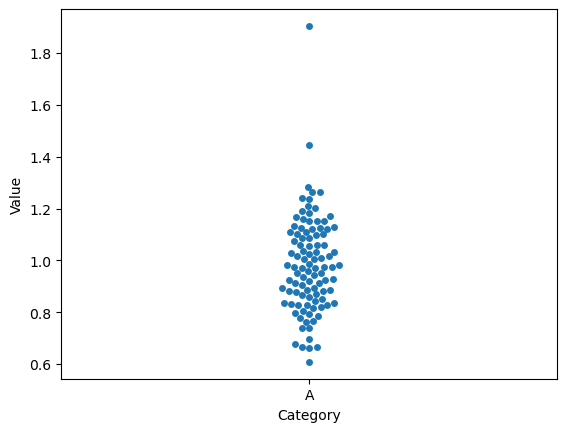

In [117]:
sns.swarmplot(x='Category', y='Value', data=df)

In [34]:
error_matrices = []

num_templates = 10
num_iters = 100

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]

measurement_error = gaussian_noise_std
num_probes = num_monomers

key = jax.random.PRNGKey(42)
keys = jax.random.split(key, num_iters)
for x in tqdm(jnp.logspace(0, 3, 4)):
    max_observation_number = 100
    num_observation_list = np.random.randint(1, high=max_observation_number, size=num_templates) 
    observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]
    observation_list = np.concatenate([*observation_list])
    observation_class_list = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
    observations_flatten = jnp.array([generate_flatten_distance_map(t) for t in observation_list])
    error_matrices.append(jax.vmap(simulation, in_axes=0)(keys))

  0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
norm_error_matrices = []
for sample in tqdm(error_matrices):
    err_list = []
    for s in sample:
        err = s/(num_monomers ** 2)
        r, c = linear_sum_assignment(err)
        err_list.append(float(err[r, c].mean()))
    norm_error_matrices.append(err_list)
    
norm_error_matrices = np.array(norm_error_matrices)

  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
data = {'Category': ['A']*num_iters + ['B']*num_iters +['C']*num_iters + ['D']*num_iters, 'Value': norm_error_matrices.flatten()}

In [38]:
df = pd.DataFrame(data)

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Category', ylabel='Value'>

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


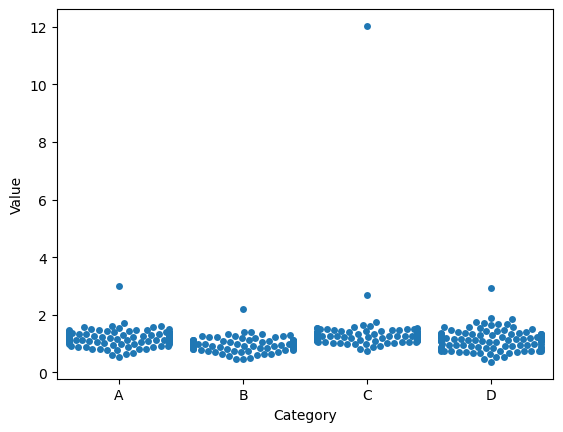

In [39]:
sns.swarmplot(x='Category', y='Value', data=df)

In [59]:
dmaps_flat = np.array([generate_flatten_distance_map(x) for x in template_chain_list])

In [98]:
centroid = np.mean(dmaps_flat, axis=0)

In [99]:
np.mean(np.sqrt(np.sum((centroid - dmaps_flat)**2, axis=-1)))/num_monomers**2

1.453436212966391

In [87]:
np.mean(np.sqrt(np.sum((np.mean(dmaps_flat, axis=0) - dmaps_flat)**2, axis=-1)))/num_monomers**2

1.453436212966391

In [100]:
# Function to calculate bootstrap samples
def bootstrap(data, n_bootstrap):
    n = len(data)
    bootstrap_samples = np.random.choice(data, size=(n_bootstrap, n), replace=True)
    return bootstrap_samples

# Function to calculate the bootstrap mean
def bootstrap_mean(data, n_bootstrap):
    samples = bootstrap(data, n_bootstrap)
    return np.mean(samples, axis=1)


In [106]:
# Number of bootstrap samples
n_bootstrap = 10000

# Calculate bootstrap means
bootstrap_means = bootstrap_mean(norm_error_matrices[3], n_bootstrap)

# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)
confidence_interval = (lower_bound, upper_bound)

confidence_interval

(1.0640859768763185, 1.210332168750465)

In [104]:
confidence_interval

(0.9355474511906505, 1.0266766573414208)

In [57]:
dist_between_models[r, c].sum()

Array(9790.28, dtype=float32)

In [54]:
r, c = linear_sum_assignment(-dist_between_models)
float(dist_between_models[r, c].mean())/num_monomers**2

2.447570037841797

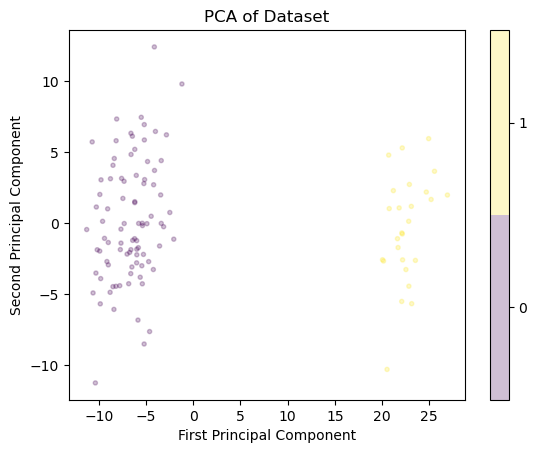

In [25]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations_flatten)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=observation_class_list, alpha=0.25)
plt.colorbar(boundaries=np.arange(num_templates+1)-0.5).set_ticks(np.arange(num_templates))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [52]:
np.array(init_model).shape

(2, 400)

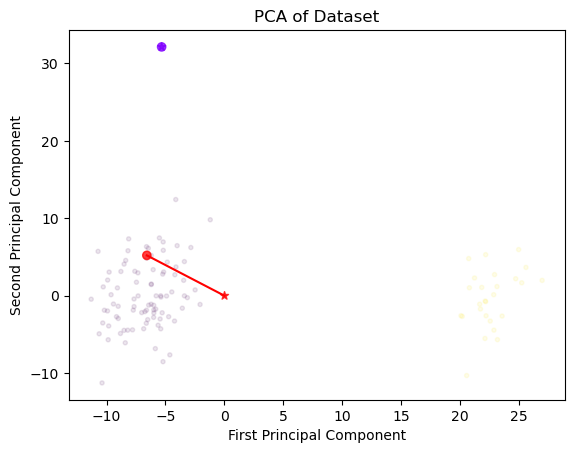

In [27]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

num_models = num_templates
cmap = plt.get_cmap('rainbow', num_models)
colors = cmap(np.linspace(0, 1, num_models))


# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations_flatten)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

init_model_scaled = scaler.transform(init_model)
init_model_pca = pca.transform(init_model_scaled)

sol_scaled = scaler.transform(pg_sol.params)
sol_pca = pca.transform(sol_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.',c=observation_class_list, alpha=0.1)
plt.scatter(init_model_pca[:, 0], init_model_pca[:, 1], marker='o', color=colors, alpha=0.75)
plt.scatter(sol_pca[:, 0], sol_pca[:, 1], marker='*', color=colors, alpha=0.75)

for i in range(num_models):
    plt.plot(np.concatenate([[init_model_pca[i, 0], sol_pca[i, 0]]]), np.concatenate([[init_model_pca[i, 1], sol_pca[i, 1]]]), color=colors[i])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

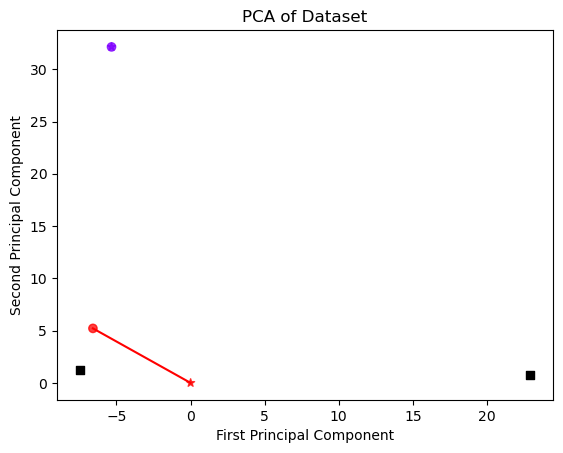

In [30]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('rainbow', num_models)
colors = cmap(np.linspace(0, 1, num_models))


cmap_model = plt.get_cmap('viridis', 10)
colors_model = cmap_model(np.linspace(0, 1, 10))

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations_flatten)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

template_scaled = scaler.transform(dmaps_flat)
template_pca = pca.transform(template_scaled)

init_model_scaled = scaler.transform(init_model)
init_model_pca = pca.transform(init_model_scaled)

sol_scaled = scaler.transform(pg_sol.params)
sol_pca = pca.transform(sol_scaled)

# Visualize results
plt.scatter(template_pca[:, 0], template_pca[:, 1], color='black', marker='s', alpha=1)
plt.scatter(init_model_pca[:, 0], init_model_pca[:, 1], marker='o', color=colors, alpha=0.75)
plt.scatter(sol_pca[:, 0], sol_pca[:, 1], marker='*', color=colors, alpha=0.75)

for i in range(num_models):
    plt.plot(np.concatenate([[init_model_pca[i, 0], sol_pca[i, 0]]]), np.concatenate([[init_model_pca[i, 1], sol_pca[i, 1]]]), color=colors[i])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [41]:
from scipy.spatial.distance import cdist


In [57]:
def compare_distance_maps(chain1, chain2, type1='polymer', type2='polymer'):
    """ Plot distance maps of chain1 and chain2 side-by-side
    
    Parameters
    ----------
    chain1
    chain2 
    type1
    type2

    """
    assert type1 in ('polymer', 'distance_map', 'flatten_distance_map')
    assert type2 in ('polymer', 'distance_map', 'flatten_distance_map')
    # Calculate pairwise distance maps
    if type1 == 'polymer':
        distance_map1 = squareform(pdist(chain1))
    elif type1 == 'flatten_distance_map':
        distance_map1 = np.reshape(chain1, [round(np.sqrt(chain1.shape[0])), round(np.sqrt(chain1.shape[0]))])
    else:
        distance_map1 = chain1
        
    if type2 == 'polymer':
        distance_map2 = squareform(pdist(chain2)) 
    elif type2 == 'flatten_distance_map':
        distance_map2 = np.reshape(chain2, [round(np.sqrt(chain2.shape[0])), round(np.sqrt(chain2.shape[0]))])
    else:
        distance_map2 = chain2
    
    # Initialize new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot distance maps 
    heatmap1 = ax1.imshow(distance_map1, cmap='hot', aspect='auto')
    ax1.set_title('Chain 1')
    cb1 = fig.colorbar(heatmap1, ax=ax1)
    cb1.set_label('Euclidean distance [a.u.]')
    
    heatmap2 = ax2.imshow(distance_map2, cmap='hot', aspect='auto')
    ax2.set_title('Chain 2')
    cb2 = fig.colorbar(heatmap2, ax=ax2)
    cb2.set_label('Euclidean distance [a.u.]')
    
    # Display the figure
    plt.tight_layout()
    plt.show()

In [51]:
prediction_error(pg_sol.params, dmaps_flat)

1.9128756495678307

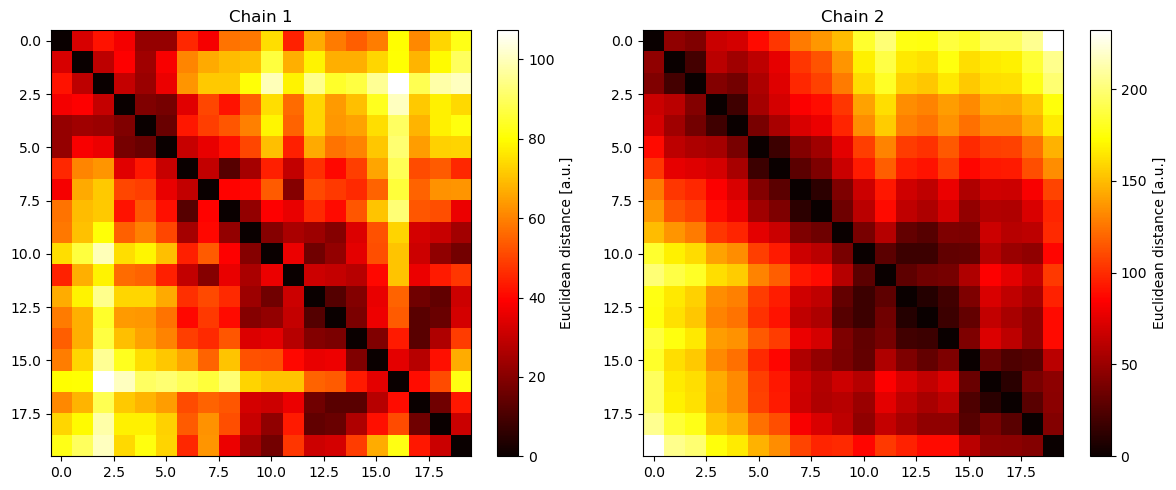

In [59]:
compare_distance_maps(pg_sol.params[0], dmaps_flat[0], type1='flatten_distance_map', type2='flatten_distance_map')

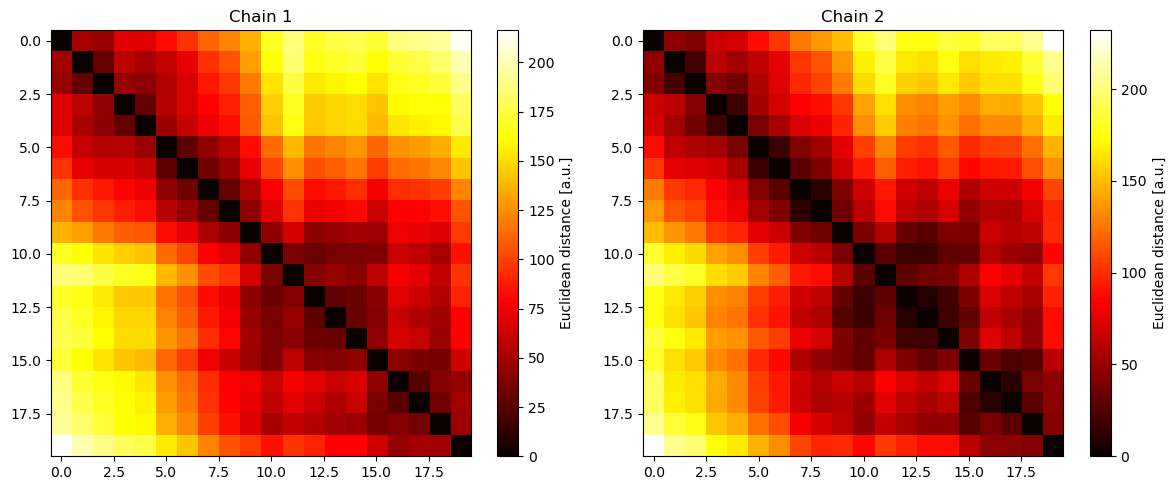

In [60]:
compare_distance_maps(pg_sol.params[1], dmaps_flat[0], type1='flatten_distance_map', type2='flatten_distance_map')